<a href="https://colab.research.google.com/github/Shrutikapedamkar/british-airways-virtual-internship/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/British_Airways_Virtual_Internship/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

# **Exploratory Data Analysis**

In [9]:
df.shape

(50000, 14)

In [10]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [11]:
df.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

In [12]:
df.count()

num_passengers           50000
sales_channel            50000
trip_type                50000
purchase_lead            50000
length_of_stay           50000
flight_hour              50000
flight_day               50000
route                    50000
booking_origin           50000
wants_extra_baggage      50000
wants_preferred_seat     50000
wants_in_flight_meals    50000
flight_duration          50000
booking_complete         50000
dtype: int64

In [13]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

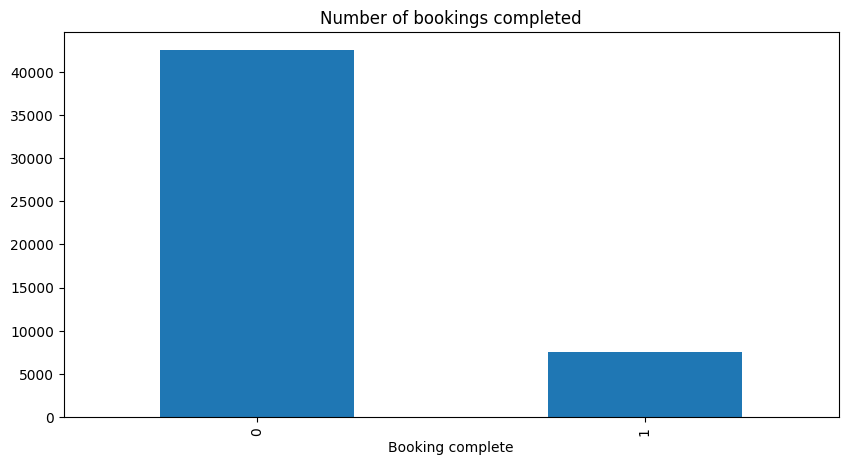

In [14]:
axis = df.booking_complete.value_counts().sort_index().plot(
              kind ='bar',
              figsize = (10,5),
    )
plt.title("Number of bookings completed")
plt.xlabel('Booking complete')
plt.show()

# **Mutual Information**
a quantity that measures a relationship between two random variables that are sampled simultaneously

In [15]:
X= df.drop('booking_complete', axis = 1)
y= df.booking_complete

In [16]:
#converting the object type to integer to calcualte mutual info
for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize()

X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [17]:
mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info, name = "Mutual Info Scores", index = X.columns)
mutual_info = mutual_info.sort_values(ascending = False)

In [18]:
mutual_info

route                    0.053093
booking_origin           0.046060
flight_duration          0.016806
wants_extra_baggage      0.012393
length_of_stay           0.008532
flight_day               0.003627
wants_in_flight_meals    0.003279
sales_channel            0.002965
trip_type                0.002692
wants_preferred_seat     0.002243
purchase_lead            0.002167
num_passengers           0.000769
flight_hour              0.000000
Name: Mutual Info Scores, dtype: float64

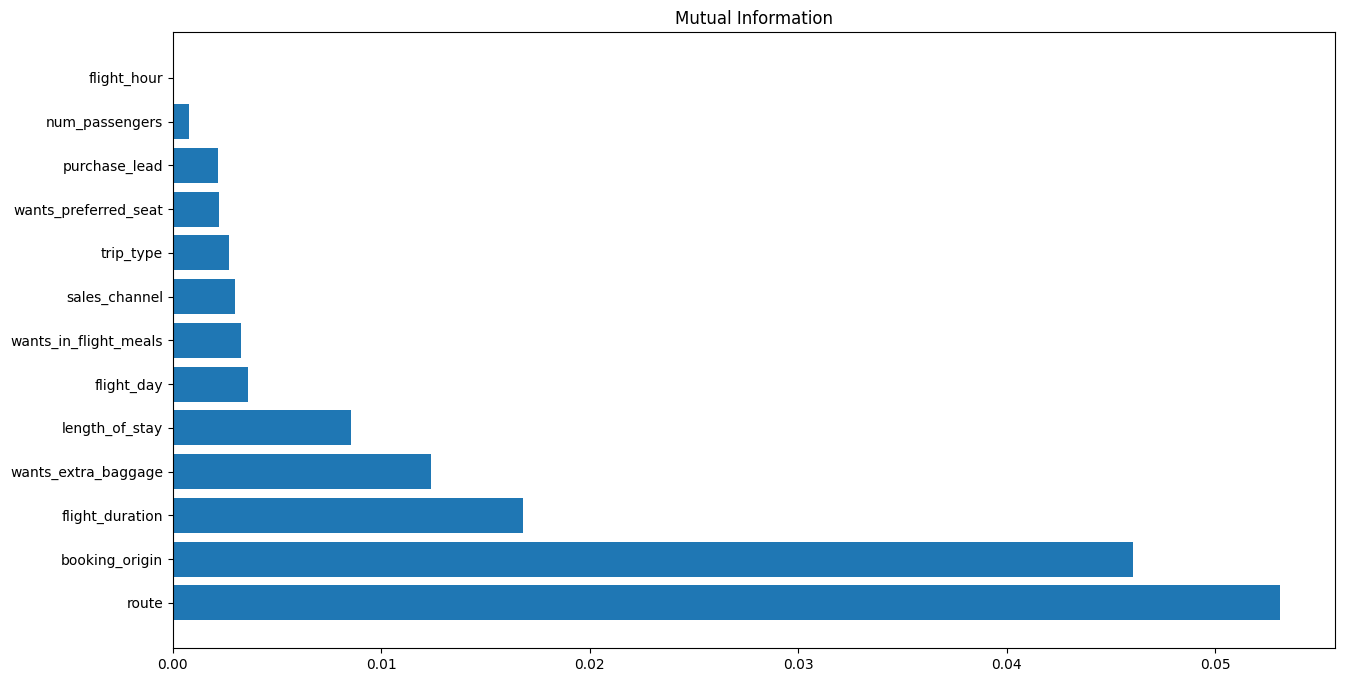

In [19]:
#Lets plot the mutual information on a bar graph

def plot_mutual_info(score) :
  width = np.arange(len(score))
  ticks = list(score.index)
  plt.barh(width, score)
  plt.yticks(width, ticks)
  plt.title("Mutual Information")

plt.figure(dpi = 100, figsize = (15,8))
plot_mutual_info(mutual_info)

From the mututal score obtained, we can say that out top 5 features are:

route, booking_origin, flight_duration, wants_extra_baggage, length_of_stay

These features are the once that are more closely related to our target variable 'booking_complete'


In [20]:
#Function to split training and testing dataset
def split_train_test(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return (X_train, X_test, y_train, y_test)

In [21]:
def scale_feature_dataset(X) :
  scaler = MinMaxScaler()
  scaler.fit(X)
  return X

## **Performing Random Classification algorithm with only 5 top features**

In [45]:
feature = ['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay']
X=df[feature]
X.head()

,route,booking_origin,flight_duration,wants_extra_baggage,length_of_stay
0,AKLDEL,New Zealand,5.52,1,19
1,AKLDEL,New Zealand,5.52,0,20
2,AKLDEL,India,5.52,1,22
3,AKLDEL,New Zealand,5.52,0,31
4,AKLDEL,India,5.52,1,22


In [46]:
#Since we have categorical values in our features column, we convert them to numerical using One hot encoding
X = pd.get_dummies(X, columns = feature)
X=scale_feature_dataset(X)
y= df.booking_complete
X.head()

,route_AKLDEL,route_AKLHGH,route_AKLHND,route_AKLICN,route_AKLKIX,route_AKLKTM,route_AKLKUL,route_AKLMRU,route_AKLPEK,route_AKLPVG,...,length_of_stay_510,length_of_stay_513,length_of_stay_517,length_of_stay_532,length_of_stay_573,length_of_stay_577,length_of_stay_603,length_of_stay_610,length_of_stay_773,length_of_stay_778
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = split_train_test(X,y)
#Hypertuning parameters to get the best parameters
param_grid = {
    'n_estimators' : [25,50,75,100],
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' :[3,6,9],
    'max_leaf_nodes' :[3,6,9]
}
#Using GridSearchCV to get the best parameters for the model
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25}


In [47]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)

In [48]:
print("Accuracy: ", accuracy_score(y_test, pred)*100)
print(classification_report(y_test, pred))

Accuracy:  85.14
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8487
           1       0.53      0.15      0.24      1513

    accuracy                           0.85     10000
   macro avg       0.70      0.56      0.58     10000
weighted avg       0.82      0.85      0.81     10000



In [49]:
#Performing Random forest classification on all features
X = df.drop('booking_complete', axis = 1)
X = pd.get_dummies(X)
X=scale_feature_dataset(X)
y= df.booking_complete
X.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Internet,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,6,1,0,0,5.52,1,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,1,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,1,...,0,0,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,1,...,0,0,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,1,...,0,0,0,0,0,0,0,0,0,0


In [50]:
random_forest_all = RandomForestClassifier(random_state=42)
random_forest_all.fit(X_train, y_train)
pred = random_forest_all.predict(X_test)

In [51]:
print("Accuracy: ", accuracy_score(y_test, pred)*100)
print(classification_report(y_test, pred))

Accuracy:  85.14
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8487
           1       0.53      0.15      0.24      1513

    accuracy                           0.85     10000
   macro avg       0.70      0.56      0.58     10000
weighted avg       0.82      0.85      0.81     10000



## **XGB Classifier with top 5 features**

In [54]:
X = df[feature]
X = pd.get_dummies(X, columns=feature)
X = scale_feature_dataset(X)
y = df.booking_complete
X_train, X_test, y_train, y_test = split_train_test(X,y)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print('ACCURACY: ',accuracy_score(y_test, pred_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,pred_xgb))

ACCURACY:  84.8
AUC score:  0.5240276116086257


In [55]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale_feature_dataset(X)
y= df.booking_complete

X_train,X_test,y_train,y_test= split_train_test(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)
print('ACCURACY: ',accuracy_score(y_test, pred_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,pred_xgb))

ACCURACY:  84.89999999999999
AUC score:  0.5414531972268773
